This Notebook was built with the purpose of understanding how to compute gradients and optimization routines with Graph Nets library. The compatibility between keras, tensorflow and Graph Nets is not fully supported. There are some grey areas which make all the standard implementation fails. Specifically, it is needed among other things to use the Adam optimizer of the Sonnet module. This was only discovered thanks to the notebook from the demo of graph nets 2 (the only example compatible with tensorflow2) called sort.py at the link:
Minor adjustment in the source code are needed to run the notebook sort.ipynb. 
The pipeline for this notebook was: 
0) Understanding how the custom gradient implementation of tensorflow behaves
1) taking the most naive version from the implementation of the main code
2) Comparing step by step the sort.ipynb notebook with the structure needed for our work
3) Finding out how to compute gradients (None values were ubiquitos initially)
4) subsequently understanding how to apply the optimizer to this naive version 
5) Increasing the complexity in order to implement IT-SWO 
    Point 5 can be subsequently divided in subtasks:
        5.1)
        5.2)
        5.3)


## Step 0: 
Of course there are plenty of other examples, this is just a representative one for comparison.


In [1]:
import tensorflow as tf
@tf.custom_gradient
def custom_relu2(x):
    def relu_grad(dy):
        grad=  tf.cast( x > 0, dtype=tf.float32)*dy
        return grad
    return tf.maximum(x, 0.), relu_grad
data = tf.Variable([0.5, -0.2, 0.0, -2.5, 3.0], dtype=tf.float32)


2024-05-06 13:25:39.003059: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-06 13:25:39.008700: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-06 13:25:39.075972: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 13:25:39.903111: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-06 13:25:41.146408: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-06 13:25:41.146894: W tensorflow/co

In [2]:
import tensorflow as tf

@tf.custom_gradient
def custom_relu(x):
    def relu_forward(x):
        return tf.maximum(x, 0)
    
    def relu_grad(dy):
        grad = tf.cast(x > 0, dtype=tf.float32) * dy
        return grad

    return relu_forward(x), relu_grad

# Define a trainable variable
w = tf.Variable([1.0], dtype=tf.float32)  # A simple weight variable

# Define an input
x = tf.constant([1.0, -1.0, -2.0, 2.0, 3.0], dtype=tf.float32)

# Define an optimizer
optimizer = tf.optimizers.SGD(learning_rate=0.01)

for step in range(3):
    with tf.GradientTape() as tape:
        y = custom_relu(w * x)  # Apply ReLU to a linear transformation of x
        print(y, type(y))
        # Compute gradients of y with respect to w
        gradients = tape.gradient(y, w)
        print(gradients)
        # Apply gradients to update w
        optimizer.apply_gradients(zip([gradients], [w]))

        print("Updated w:", w.numpy())



tf.Tensor([1. 0. 0. 2. 3.], shape=(5,), dtype=float32) <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([6.], shape=(1,), dtype=float32)
Updated w: [0.94]
tf.Tensor([0.94 0.   0.   1.88 2.82], shape=(5,), dtype=float32) <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([6.], shape=(1,), dtype=float32)
Updated w: [0.88]
tf.Tensor([0.88      0.        0.        1.76      2.6399999], shape=(5,), dtype=float32) <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([6.], shape=(1,), dtype=float32)
Updated w: [0.82]


## Step 1 




In [3]:
import tensorflow as tf
import sonnet as snt
from graph_nets import modules

hidden_layer_size=4   #This will be 128
output_emb_size=4      #This has to be 64 at the end
# Define the MLP model
class MLPModel_glob(snt.Module):
    def __init__(self, name=None):
        super(MLPModel_glob, self).__init__(name=name)
        self.layer1 = snt.Linear(output_size=hidden_layer_size, name='Glob_layer')
       

    def __call__(self, inputs):
        out = tf.nn.relu(self.layer1(inputs))
        
        return out
class MLPModel_enc(snt.Module):
    def __init__(self, name=None):
        super(MLPModel_enc, self).__init__(name=name)
        self.layer1 = snt.Linear(output_size=hidden_layer_size, name='enc_layer')
        

    def __call__(self, inputs):
        out = tf.nn.relu(self.layer1(inputs))

        return out

# Define the Encoder layer
class Encoder(modules.GraphNetwork):
    def __init__(self):
        super(Encoder, self).__init__(
            edge_model_fn=MLPModel_enc,
            node_model_fn=MLPModel_enc,
            global_model_fn=MLPModel_glob
        )

    def __call__(self, inputs):
        return super(Encoder, self).__call__(inputs)

    
class MLPModel_dec(snt.Module):
    def __init__(self, name=None):
        super(MLPModel_dec, self).__init__(name=name)
        self.layer1 = snt.Linear(output_size=hidden_layer_size, name='dec_layer')

    def __call__(self, inputs):
        out = tf.nn.relu(self.layer1(inputs))

        return out

class Decoder(modules.GraphNetwork):
    def __init__(self):
        super(Decoder, self).__init__(
            edge_model_fn=MLPModel_dec,
            node_model_fn=MLPModel_dec,
            global_model_fn=MLPModel_glob
        )

    def __call__(self, inputs):
        return super(Decoder, self).__call__(inputs)    
class PoolingLayer_double(tf.Module):
    def __init__(self):
        super(PoolingLayer_double, self).__init__()
        self.linear = snt.Linear(output_size=2, name='linear_pool')
        self.global_transform = snt.Linear(output_size=2, name='global_transform')

    def __call__(self, inputs):
        # Sum-pooling over nodes and edges
        pooled_nodes = tf.reduce_sum(inputs.nodes, axis=0)
        pooled_edges = tf.reduce_sum(inputs.edges, axis=0)
        pooled_features = tf.concat([pooled_nodes, pooled_edges], axis=0)
        
        transformed = self.linear(tf.expand_dims(pooled_features, axis=0))
        
        # Transform globals to match the shape of transformed
        transformed_globals = self.global_transform(0.05 *inputs.globals)
        #### THIS IS THE MOST RELEVANT PART, why again I can not use elu here? Is something related to the metric as well
        out = tf.nn.elu(transformed + transformed_globals)
        
        return out    
class GNN_double_output(snt.Module):
    def __init__(self):
        super(GNN_double_output, self).__init__()
        self.encoder = Encoder()
        self.pooling_layer = PoolingLayer_double()

    def __call__(self, inputs):
        encoded = self.encoder(inputs)

        output = self.pooling_layer(encoded)
        return output

In [7]:
import numpy as np
import time
import networkx as nx
from graph_nets import utils_np, utils_tf
from compgraph.useful import node_to_index
# Set a random seed
start=time.time()
SEED = 1
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Define the lattice size
lattice_size = (2,2)
#Batch size, the number of graphs that will be computed simultaneously by the GNN
batch_size= 4

# Create a square lattice
G = nx.grid_2d_graph(*lattice_size, periodic=True)
# Number of sites
num_sites = lattice_size[0] * lattice_size[1]

# Relabel the nodes to use integers
mapping = node_to_index(G)

G = nx.relabel_nodes(G, mapping)
# Initialize the sublattice encoding
sublattice_encoding = np.zeros((num_sites, 2))  # Two sublattices
sublattice_encoding[::2, 0] = 1  # Sublattice 1
sublattice_encoding[1::2, 1] = 1  # Sublattice 2
# Create a dictionary where the keys are the node indices and the values are dictionaries
# containing the 'features' field and the corresponding sublattice encoding
node_dict = {i: {"features": sublattice_encoding[i]} for i in range(num_sites)}
# Use the dictionary to set the node attributes in the graph
#nx.set_node_attributes(G, node_dict)
# Add 'features' to nodes
for node in G.nodes():
    G.nodes[node]['features'] = sublattice_encoding[node]
# Add 'features' to edges
# Add 'features' to edges
for edge in G.edges():
    u, v = edge
    G.edges[u, v]['features'] = [1.0]  # Replace with your actual edge features
    G.edges[v, u]['features'] = [1.0]  # Add undirected edge # Replace with your actual edge features
# Now convert the networkx graph to a GraphsTuple
graph_tuple = utils_np.networkxs_to_graphs_tuple([G])

# Number of configurations to generate
n_configs = 6
n_graph=n_configs*batch_size
# Generate the basis configurations
basis_configs = np.random.randint(2, size=(n_graph, num_sites)) * 2 - 1  # Random spins (-1 or 1)

# Concatenate the basis configurations and the sublattice encoding to form the node features
node_features = np.concatenate([basis_configs[:, :, np.newaxis], np.repeat(sublattice_encoding[np.newaxis, :, :], len(basis_configs), axis=0)], axis=2)

# Get the edge indices
edge_index = np.array(G.edges()).T
edge_index_duplicated = np.concatenate([edge_index, edge_index[::-1]], axis=1)
bias_value=0.5
# Create a list of graph dicts
graph_tuples = []
for i in range(n_graph):
    graph_dict = {
        'globals': np.array([0.05]),
        'nodes': node_features[i],
        'edges': np.full((edge_index_duplicated.shape[1], 1), bias_value),
        'senders': edge_index_duplicated[0],
        'receivers': edge_index_duplicated[1]
    }
    
    # Convert to a GraphsTuple and append to the list
    graph_tuples.append(utils_tf.data_dicts_to_graphs_tuple([graph_dict]))


print("end time:", time.time()-start)

end time: 0.1337597370147705


In [8]:
from useful import create_graph_tuples, compare_graph_tuples
graph_tuples2=create_graph_tuples(basis_configs,G,sublattice_encoding)


# Usage:
result = compare_graph_tuples(graph_tuples2, graph_tuples)
print("Graphs are equal:", result)

Graphs are equal: True


In [9]:
# Instantiate the model
simple_gnn = GNN_double_output()
for i in range(1):
    a,b =simple_gnn(graph_tuples[i])[0]
    print(a,b)

tf.Tensor(1.8513225677819865, shape=(), dtype=float64) tf.Tensor(1.0092861107726787, shape=(), dtype=float64)


In [10]:
def mock_loss_function(amplitude, phase):
    """A mock loss function for illustration purposes h"""
    return tf.abs(1- phase*amplitude**2)


## Step 2 to 4
Most of the work here was done by trial and error and a lot of print statements among other strategies. 
The end result looks decently clean but the hidden work behind was quite intensive.
Observations: sonnet modules seems to not be compatible with keras optimizers built on tensorflow. We need to use the sonnet optimizers.
Furthermore, the sonnet optimizer does not allow for a learning schedule with Exponential decay as was intended to be used initially. 
The only useful implementation is of the standard Adam optimization routine. (Trivial SGD is inadequate for so many parameters, ca va sans dire)
No fancy version of Adam are available, maybe it is for the best though.

In [11]:
#import sonnet as snt
#initial_learning_rate = 7e-3
#decay_steps = 8 * 1e5
#decay_rate = 0.1
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate, decay_steps, decay_rate, staircase=True)
#print(lr_schedule)
#optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.99, clipnorm=1)


In [12]:
initial_learning_rate = 7e-3
optimizer = snt.optimizers.Adam(initial_learning_rate,0.9)

def train_step(model, input_graph, optimizer):

    with tf.GradientTape() as tape:
        output = model(input_graph)[0]

        tape.watch(model.trainable_variables)
        print("output: \n", output)
        amplitude, phase = output
        print(amplitude, phase, "types", type(amplitude), type(phase))
            
        loss = mock_loss_function(amplitude,phase)
            
    #print("model variables: \n",model.trainable_variables) -< those are fine and are all tf.variables
    print("Is it lossing: \n", loss, type(loss))
    gradients = tape.gradient(loss, model.trainable_variables)
    #print("are model variables and gradients two lists?", type(model.trainable_variables), type(gradients))

    #print("model gradients: \n", gradients)
    #for var, grad in zip(model.trainable_variables, gradients):
    #    print(f"{var.name}: Gradient {'is None' if grad is None else 'exists'}")
    optimizer.apply(gradients, model.trainable_variables)
    
    return output, loss

np.set_printoptions(precision=2)
# Training loop
for step in range(1):
    #print(graph_tuples[0])
    outputs, loss = train_step(simple_gnn, graph_tuples[0], optimizer)
    if step % 1 == 0:
        print(f"Step {step}, Loss: {loss.numpy()}")


output: 
 tf.Tensor([1.85 1.01], shape=(2,), dtype=float64)
tf.Tensor(1.8513225677819865, shape=(), dtype=float64) tf.Tensor(1.0092861107726787, shape=(), dtype=float64) types <class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
Is it lossing: 
 tf.Tensor(2.459222421931945, shape=(), dtype=float64) <class 'tensorflow.python.framework.ops.EagerTensor'>
Step 0, Loss: 2.459222421931945


## Step 5
### 5.1
In this section of the notebook we are going to implement the real loss function and attempt to train a simplified model of our GNN on a 2x2 square lattice. 
The following implementation will rely on scipy sparse.
This implementation is suboptimal and is done for educational purpose. The reason is that implementing a Sparse Matrix is resource intensive regardless. The key reasoning is that one does not need to fully implement the matrix, just vector matrix multiplications, and those follow some specific patterns due to ortoghonality, plase look at step 5.2 for an implementation that does not need explicitly the matrix.



In the following cell block we generate the input graph and initialize the edges and node values

In [13]:
import numpy as np
import time
import networkx as nx
from graph_nets import utils_np, utils_tf
from compgraph.useful import neel_state, create_graph_tuples
start=time.time()
SEED = 1
np.random.seed(SEED)
tf.random.set_seed(SEED)

#Batch size, the number of graphs that will be computed simultaneously by the GNN, here they are set to 4 because the 
#total number of states is 2**4, and any value above is equivalent to optimizing the GNN on the whole hilbert space.
# We are interested in the main pipeline, and want to generalize the network to larger scales thereafter
batch_size= 4

# Define the lattice size
lattice_size = (2,2)
# Create a square lattice with periodic boundary conditions. This is expecially useful in larger graphs where
# having periodic boundary conditions allows for a more decent approximation of an infinite lattice, for small size graphs
# periodic boundary conditions have a little effect.
G = nx.grid_2d_graph(*lattice_size, periodic=True)
# Number of sites
num_sites = lattice_size[0] * lattice_size[1]

# Relabel the nodes to use integers
mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, mapping)
# Initialize the sublattice encoding
sublattice_encoding= neel_state(G)
# Create a dictionary where the keys are the node indices and the values are dictionaries
# containing the 'features' field and the corresponding sublattice encoding
node_dict = {i: {"features": sublattice_encoding[i]} for i in range(num_sites)}

# Add 'features' to nodes, in this case the feature is a one hot vector that represents the sublattice encoding of each node
"""
for node in G.nodes():
    G.nodes[node]['features'] = sublattice_encoding[node]
# Add 'features' to edges
# Add 'features' to edges
for edge in G.edges():
    u, v = edge
    G.edges[u, v]['features'] = [1.0]  # 
    G.edges[v, u]['features'] = [1.0]  # Add undirected edge 
"""

# Number of batches of configurations to generate, here is set to 4 because 4x4=2**4= Hilbert space, and we don't need more than that
n_configs = 4
n_graph=n_configs*batch_size
# Generate the basis configurations
basis_configs = np.random.randint(2, size=(n_graph, num_sites)) * 2 - 1  # Random spins (-1 or 1)




graph_tuples=create_graph_tuples(basis_configs, G, sublattice_encoding)
print("end time:", time.time()-start)



end time: 0.0942234992980957


In [14]:
print(G.edges)
print(G.nodes)


[(0, 2), (0, 1), (1, 3), (2, 3)]
[0, 1, 2, 3]


In [15]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from compgraph.gnn_src_code import GNN_double_output

from compgraph.sparse_ham import create_spin_operators_qutipv5, construct_sparse_hamiltonian
from compgraph.useful import sites_to_sparse

configurations, value_list= sites_to_sparse(basis_configs)
# Uncomment the following line to see the distribution of the initial random configurations
#plt.plot(np.sort(value_list))
#Here we noticed that the second environment created is not compatible for some obscure reasons, probably qutip compatibility. We are gonna stick to this one for now. ASK patrick

J2=2.0
Hamiltonian = construct_sparse_hamiltonian(G, 0)
less_trivial_gnn=GNN_double_output()


In [17]:
import time
import numpy as np
import tensorflow as tf
#reload(compgraph.tensor_wave_functions)

from compgraph.sparse_ham import compute_wave_function_csr,  innerprod_sparse
from compgraph.tensor_wave_functions import adjust_dtype_and_multiply, convert_csr_to_sparse_tensor, variational_wave_function_on_batch

#THE inner training step should work for one configuration at a time if logic has any ground on reality
np.set_printoptions(precision=2, suppress=True)
optimizer_snt = snt.optimizers.Adam(initial_learning_rate,0.9)
Hamiltonian_tensor = convert_csr_to_sparse_tensor(Hamiltonian)
beta=0.005
def evolving_function(wave, Ham_tensor,beta):
    wave=tf.sparse.reorder(wave)
    auxphi= adjust_dtype_and_multiply(Ham_tensor,wave)
    beta *= -1
    phi=tf.sparse.map_values(tf.multiply,auxphi, beta)
    #print(wave.indices,phi.indices)
    
    phi=tf.sparse.add(wave,tf.stop_gradient(phi))
    #print(phi)
    wave_with_0=tf.sparse.map_values(tf.multiply,phi, 0)
    wave=tf.sparse.add(wave,wave_with_0)
    psi_conj= tf.sparse.map_values(tf.math.conj, wave)
    overlap=tf.sparse.map_values(tf.multiply,psi_conj,phi)
    norm_wave = tf.norm(wave.values)
    norm_ito_wave=tf.norm(phi.values)
    normalization=1/(norm_wave*norm_ito_wave)
    #print(normalization, 'This is the coefficient at denominator')
    overlap_normalized=tf.sparse.map_values(tf.multiply,overlap,normalization)
    loss=tf.reduce_sum(overlap_normalized.values)
    print('Lossing final', loss)
    return -loss
def sparse_rep_inner_training_step(model, graph_batch, graph_batch_indices, target_phi, optimizer):

    with tf.GradientTape() as tape:
        output = variational_wave_function_on_batch(model, graph_batch)

        tape.watch(model.trainable_variables)
        print("output: \n", output)
            
        loss = evolving_function(output, Hamiltonian_tensor, beta)
            
    #print("model variables: \n",model.trainable_variables) -< those are fine and are all tf.variables
    print("Is it lossing: \n", loss, type(loss))
    gradients = tape.gradient(loss, model.trainable_variables)
    #print("are model variables and gradients two lists?", type(model.trainable_variables), type(gradients))

    #print("model gradients: \n", gradients)
    #for var, grad in zip(model.trainable_variables, gradients):
    #    print(f"{var.name}: Gradient {'is None' if grad is None else 'exists'}")
    optimizer_snt.apply(gradients, model.trainable_variables)
    
    return output, loss


start=0
for step in range(10):  # IT-SWO steps
    # Compute phi once at the beginning of each outer step, this is the ITO of psi
    start =start%len(graph_tuples)
    end=(start + batch_size)
    graph_tuples_batch=graph_tuples[start:end]
    graph_tuples_batch_indices= configurations[start:end]
    print(start,end, len(configurations),len(graph_tuples))
    psi_csr = compute_wave_function_csr(graph_tuples_batch, less_trivial_gnn, graph_tuples_batch_indices)
    
    beta = 0.05 #This parameter determines the amount of imaginary time evolution at each outer step
    phi_csr = psi_csr - beta * Hamiltonian.dot(psi_csr)
    print("Inner product scipy sparse", innerprod_sparse(phi_csr, phi_csr))
    for innerstep in range(2):  # Inner loop iterations: here we let psi approximate its ITO phi

        outputs, loss = sparse_rep_inner_training_step(less_trivial_gnn, graph_tuples_batch, graph_tuples_batch_indices, phi_csr, optimizer)
       
        #print(outputs,loss)
        if step % 1 == 0:
            print(f"Step {step}, Loss: {loss.numpy()}")
        
        
    # Update the start index for the next batch
    start += batch_size



0 4 16 16
Inner product scipy sparse   (0, 0)	(0.2532032102385702+0j)
output: 
 SparseTensor(indices=tf.Tensor(
[[ 6  0]
 [ 9  0]
 [12  0]
 [15  0]], shape=(4, 2), dtype=int64), values=tf.Tensor([ 0.01+0.25j  0.01+0.25j  0.  +0.28j -0.04+0.23j], shape=(4,), dtype=complex128), dense_shape=tf.Tensor([16  1], shape=(2,), dtype=int64))
Lossing final tf.Tensor((0.9984529390193818+1.734723475976807e-18j), shape=(), dtype=complex128)
Is it lossing: 
 tf.Tensor((-0.9984529390193818-1.734723475976807e-18j), shape=(), dtype=complex128) <class 'tensorflow.python.framework.ops.EagerTensor'>
Step 0, Loss: (-0.9984529390193818-1.734723475976807e-18j)
output: 
 SparseTensor(indices=tf.Tensor(
[[ 6  0]
 [ 9  0]
 [12  0]
 [15  0]], shape=(4, 2), dtype=int64), values=tf.Tensor([0.14+1.53j 0.14+1.53j 0.12+1.52j 0.02+1.55j], shape=(4,), dtype=complex128), dense_shape=tf.Tensor([16  1], shape=(2,), dtype=int64))
Lossing final tf.Tensor((0.9983045617348313+0j), shape=(), dtype=complex128)
Is it lossing: 
 t

# 5.1.b
In the following we are taking the full Hilbert space as per the configurations batch to consider. The trained Network generates an approximate ground state.

In [18]:

import compgraph
from compgraph.useful import sites_to_sparse
from compgraph.useful import create_graph_from_ham

lattice_size = (2, 2)
sublattice_encoding = neel_state(nx.grid_2d_graph(*lattice_size, periodic=True)) 
G=create_graph_from_ham(geometric_structure="2d_square", lattice_size=lattice_size, sub_lattice_encoding=sublattice_encoding)

# Number of batches of configurations to generate, here is set to full Hilbert space
full_size_configs = 2**(len(G.nodes))
# Generate the basis configurations
print(full_size_configs, sublattice_encoding)
full_basis_configs = np.array([[int(x) for x in format(i, f'0{len(G.nodes)}b')] for i in range(full_size_configs)]) * 2 - 1


#Initialization of edges, it should be 0, we set it to 0.05.
bias_value=0.05
# Create a list of graph dicts
full_graph_tuples =create_graph_tuples(full_basis_configs, G, sublattice_encoding, 0.05, 0.5)

full_configurations, value_list= sites_to_sparse(full_basis_configs)

#for idx, config in enumerate(full_configurations):
#    print(np.array(config), full_basis_configs[idx], value_list[idx])


16 [[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [19]:
from compgraph.useful import graph_tuple_toconfig
from compgraph.useful import sites_to_sparse
from compgraph.useful import neel_state, config_list_to_state_list, graph_tuple_list_to_configs_list, config_to_state
from compgraph.tensor_wave_functions import graph_tuple_to_config_hamiltonian_product
import quimb as qu
full_configurations_indices, valuelist= sites_to_sparse(full_basis_configs)

config_from_batch=graph_tuple_toconfig(full_graph_tuples[2])

print(config_from_batch,full_basis_configs[2])
print(graph_tuples_batch_indices[2])
print(full_basis_configs[2])
print(sites_to_sparse([config_from_batch])[0][0].indices[0])

print(config_from_batch)
sparse, vt= sites_to_sparse([config_from_batch])

[-1. -1.  1. -1.] [-1 -1  1 -1]
  (0, 8)	1
[-1 -1  1 -1]
2
[-1. -1.  1. -1.]


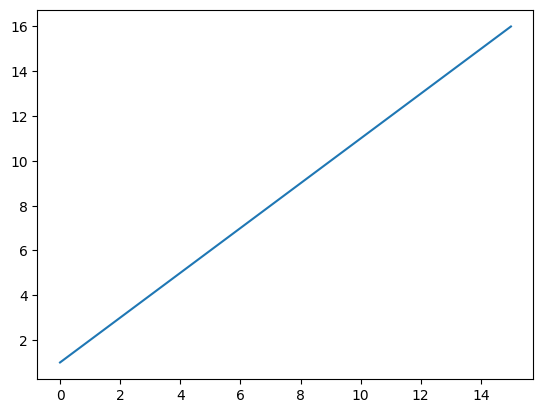

In [20]:
plt.plot((value_list))

In [21]:
import tensorflow as tf
import sonnet as snt
from compgraph.useful import copy_to_non_trainable, compare_sonnet_modules  # Importing custom functions and model class


# Initialize two instances of the same GNN architecture
model_a = GNN_double_output()
model_b = GNN_double_output()

# Assuming both models are connected to the computational graph and variables are initialized
tf.random.set_seed(42)  # For reproducibility

# Connect models to the computational graph to ensure variables are created
outa= model_a(graph_tuples[0])[0]
outb = model_b(graph_tuples[0])[0]

# Compare the two models to verify that the weights are identical
are_identical = compare_sonnet_modules(model_a, model_b)
print("The models are identical before copying:", are_identical)
copy_to_non_trainable(model_a, model_b)
are_identical2 = compare_sonnet_modules(model_a, model_b)

print("The models are identical after copying:", are_identical2)



The two modules have the same number of layers parameters
Comparison failed at index 1, gnn_double_output/graph_network/edge_block/mlp_model_enc/layer1/w:0 is different than gnn_double_output/graph_network/edge_block/mlp_model_enc/layer1/w:0
The models are identical before copying: False
The two modules have the same number of layers parameters
The models are identical after copying: True


In [27]:
import time
import numpy as np
import tensorflow as tf
import quimb as qu
from compgraph.sparse_ham import compute_wave_function_csr,  innerprod_sparse
from compgraph.tensor_wave_functions import convert_csr_to_sparse_tensor, variational_wave_function_on_batch, time_evoluted_wave_function_on_batch
from compgraph.tensor_wave_functions import montecarlo_logloss_overlap_time_evoluted, sparse_tensor_exp_energy, calculate_sparse_overlap, quimb_vec_to_sparse
initial_learning_rate = 7e-5
model_w=GNN_double_output()
model_fix=GNN_double_output()
#THE inner training step should work for one configuration at a time if logic has any ground on reality
H_no_traversalfield=construct_sparse_hamiltonian(G, 0)


np.set_printoptions(precision=2, suppress=True)
optimizer_snt = snt.optimizers.Adam(initial_learning_rate)
Hamiltonian_tensor_no_traversalfield = convert_csr_to_sparse_tensor(H_no_traversalfield)
beta=0.05

def inner_training(model_var, model_fix_for_te, graph_batch_var,graph_batch_te, optimizer, beta,sublattice):

    with tf.GradientTape() as tape:
        output = variational_wave_function_on_batch(model_var, graph_batch_var)
        te_wave_on_te= time_evoluted_wave_function_on_batch(model_fix_for_te,beta,graph_batch_te,G, sublattice)
        tape.watch(model_var.trainable_variables)
        #print("output: \n", output)
            
        loss = montecarlo_logloss_overlap_time_evoluted(te_wave_on_te, graph_batch_te, model_var, model_fix_for_te, graph_batch_var, beta, G, sublattice)
        
    #print("Is it lossing: \n", loss, type(loss))
    gradients = tape.gradient(loss, model_var.trainable_variables)
    #print("are model variables and gradients two lists?", type(model.trainable_variables), type(gradients))

    #for var, grad in zip(model.trainable_variables, gradients):
    #    print(f"{var.name}: Gradient {'is None' if grad is None else 'exists'}")
    optimizer.apply(gradients, model_var.trainable_variables)
    
    return output, loss


start=0
psi_1 = compute_wave_function_csr(graph_tuples_batch, model_w, graph_tuples_batch_indices)
psi_2= compute_wave_function_csr(graph_tuples_batch, model_fix, graph_tuples_batch_indices)
Hamiltonian_quimb= qu.ham_heis_2D(2, 2, j=1.0, bz=0, cyclic=True, parallel=False, ownership=None)
lowest_eigenstate = qu.groundstate(Hamiltonian_quimb)
lowest_eigenstate_as_sparse = quimb_vec_to_sparse(lowest_eigenstate, full_basis_configs,len(G.nodes))

energies=[]
loss_vectors=[]
overlap_in_time=[]

for step in range(90):  # IT-SWO steps
    # Compute phi once at the beginning of each outer step, this is the ITO of psi

    graph_tuples_batch=full_graph_tuples
    graph_tuples_batch_indices= full_configurations

    psi_csr = compute_wave_function_csr(graph_tuples_batch, model_w, graph_tuples_batch_indices)
    
    phi_csr = psi_csr - beta * H_no_traversalfield.dot(psi_csr)
    normaliz_sparse_prod= psi_csr.conj().transpose().dot(psi_csr)*phi_csr.conj().transpose().dot(phi_csr)
    overlap_sparse=innerprod_sparse(psi_csr, phi_csr)/(np.sqrt(normaliz_sparse_prod))
    print("Overlap from sparse", overlap_sparse)
    
    copy_to_non_trainable(model_w, model_fix)

    for innerstep in range(8):  # Inner loop iterations: here we let psi approximate its ITO phi
        
        outputs, loss = inner_training(model_w, model_fix, graph_tuples_batch, graph_tuples_batch, optimizer_snt,beta, sublattice_encoding)
       
        if step % 1 == 0:
            print(f"Step {step}, Loss: {loss.numpy()}")
         # Compute and store energy after updating weights
        psi_sparse= variational_wave_function_on_batch(model_w,graph_tuples_batch)
        normaliz_gnn= 1/tf.norm(psi_sparse.values)
        norm_low_state_gnn= tf.sparse.map_values(tf.multiply, psi_sparse, normaliz_gnn)
        current_energy = sparse_tensor_exp_energy(psi_sparse, G,0)
        overlap_temp= tf.norm(calculate_sparse_overlap(lowest_eigenstate_as_sparse,norm_low_state_gnn))
        overlap_in_time.append(overlap_temp)
        energies.append(current_energy)
        loss_vectors.append(loss.numpy())
        
    # Update the start index for the next batch
    start += batch_size

Overlap from sparse [[1.-0.j]]
Overlap according to MC function tf.Tensor((0.9985231267039213+0j), shape=(), dtype=complex128)
Step 0, Loss: (0.0007389824741994314-0j)
Overlap according to MC function tf.Tensor((0.9993475562168708+0j), shape=(), dtype=complex128)
Step 0, Loss: (0.00032632835859888726-0j)
Overlap according to MC function tf.Tensor((0.9993439065938083+0j), shape=(), dtype=complex128)
Step 0, Loss: (0.0003281543648285773-0j)
Overlap according to MC function tf.Tensor((0.9994532782397361+0j), shape=(), dtype=complex128)
Step 0, Loss: (0.0002734356335501717-0j)
Overlap according to MC function tf.Tensor((0.999664186564328+0j), shape=(), dtype=complex128)
Step 0, Loss: (0.0001679349168150932-0j)
Overlap according to MC function tf.Tensor((0.9997871687081813+0j), shape=(), dtype=complex128)
Step 0, Loss: (0.00010642697180604818-0j)
Overlap according to MC function tf.Tensor((0.9997683032003103+0j), shape=(), dtype=complex128)
Step 0, Loss: (0.00011586182277005424-0j)
Overlap 

/home/stefanotroffa/miniconda3/envs/gnets2/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/stefanotroffa/miniconda3/envs/gnets2/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


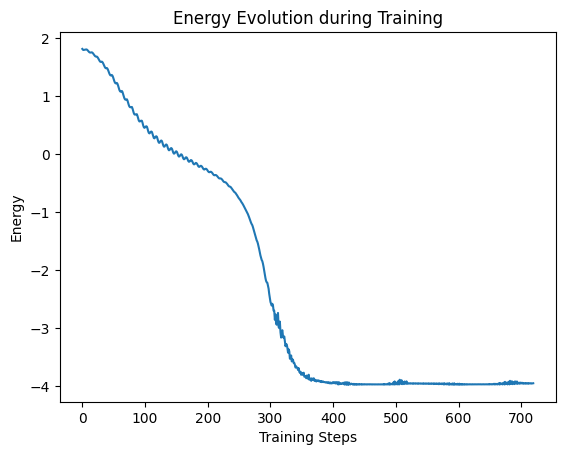

Lowest Energy calculated with quimb: -3.999999999999999
tf.Tensor(
[-0.01-0.01j -0.  +0.02j  0.  +0.01j -0.26+0.16j -0.  +0.02j -0.27+0.16j
  0.51-0.22j -0.  +0.01j  0.  +0.01j  0.51-0.22j -0.26+0.16j -0.  +0.01j
 -0.26+0.16j -0.  +0.01j -0.  +0.01j -0.01-0.01j], shape=(16,), dtype=complex128)
[[ 0.      ]
 [ 0.      ]
 [ 0.      ]
 [-0.288675]
 [ 0.      ]
 [-0.288675]
 [ 0.57735 ]
 [ 0.      ]
 [ 0.      ]
 [ 0.57735 ]
 [-0.288675]
 [ 0.      ]
 [-0.288675]
 [ 0.      ]
 [-0.      ]
 [ 0.      ]]
-3.999999999999999 tf.Tensor((-3.948733758534076-6.4543910580777686e-18j), shape=(), dtype=complex128)


In [28]:
# Plotting the energy
plt.plot(energies[:])
plt.xlabel('Training Steps')
plt.ylabel('Energy')
plt.title('Energy Evolution during Training')
plt.show()
n, m= (2,2)
lowest_energy= qu.groundenergy(Hamiltonian_quimb)
print("Lowest Energy calculated with quimb:", lowest_energy)
low_state_gnn= variational_wave_function_on_batch(model_w, graph_tuples_batch)
normaliz_gnn= 1/tf.norm(low_state_gnn.values)
norm_low_state_gnn= tf.sparse.map_values(tf.multiply, low_state_gnn, normaliz_gnn)
print(norm_low_state_gnn.values)
print(lowest_eigenstate)

energy_normalized= sparse_tensor_exp_energy(norm_low_state_gnn, G,0)
print(lowest_energy, energy_normalized)

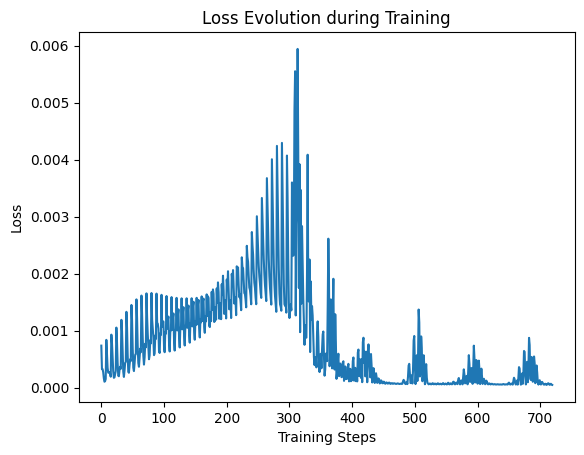

In [29]:
# Plotting the loss
plt.plot(loss_vectors[:])
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Loss Evolution during Training')
plt.show()

/home/stefanotroffa/miniconda3/envs/gnets2/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/stefanotroffa/miniconda3/envs/gnets2/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


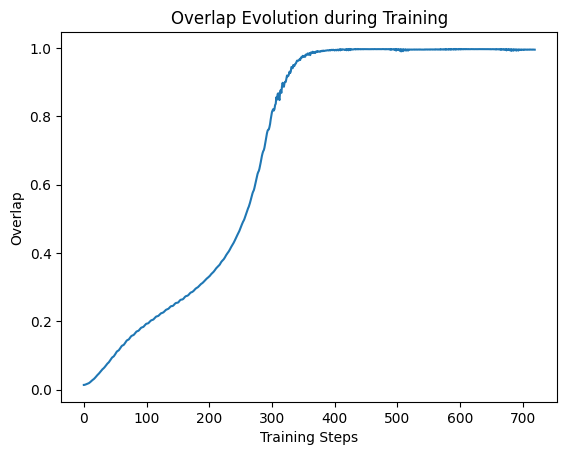

In [30]:
# Plotting the loss
plt.plot(overlap_in_time[:])
plt.xlabel('Training Steps')
plt.ylabel('Overlap')
plt.title('Overlap Evolution during Training')
plt.show()

In [ ]:
print(tf.norm(low_state_gnn.values))
norm=1/tf.norm(low_state_gnn.values)
normalized_low_state_gnn=tf.sparse.map_values(tf.multiply, low_state_gnn,norm )
print(tf.norm(normalized_low_state_gnn.values))
print(normalized_low_state_gnn.values)
print(np.array(lowest_eigenstate))


tf.Tensor((0.08188203746311772+0j), shape=(), dtype=complex128)
tf.Tensor((1+0j), shape=(), dtype=complex128)
tf.Tensor(
[-0.01-0.01j -0.  +0.02j  0.  +0.01j -0.26+0.16j -0.  +0.02j -0.27+0.16j
  0.51-0.22j -0.  +0.01j  0.  +0.01j  0.51-0.22j -0.26+0.16j -0.  +0.01j
 -0.26+0.16j -0.  +0.01j -0.  +0.01j -0.01-0.01j], shape=(16,), dtype=complex128)
[[ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [-0.29]
 [ 0.  ]
 [-0.29]
 [ 0.58]
 [ 0.  ]
 [ 0.  ]
 [ 0.58]
 [-0.29]
 [ 0.  ]
 [-0.29]
 [ 0.  ]
 [-0.  ]
 [ 0.  ]]


In [31]:
sites_to_sparse(full_basis_configs)

([<1x16 sparse matrix of type '<class 'numpy.int8'>'
  	with 1 stored elements in Compressed Sparse Row format>,
  <1x16 sparse matrix of type '<class 'numpy.int8'>'
  	with 1 stored elements in Compressed Sparse Row format>,
  <1x16 sparse matrix of type '<class 'numpy.int8'>'
  	with 1 stored elements in Compressed Sparse Row format>,
  <1x16 sparse matrix of type '<class 'numpy.int8'>'
  	with 1 stored elements in Compressed Sparse Row format>,
  <1x16 sparse matrix of type '<class 'numpy.int8'>'
  	with 1 stored elements in Compressed Sparse Row format>,
  <1x16 sparse matrix of type '<class 'numpy.int8'>'
  	with 1 stored elements in Compressed Sparse Row format>,
  <1x16 sparse matrix of type '<class 'numpy.int8'>'
  	with 1 stored elements in Compressed Sparse Row format>,
  <1x16 sparse matrix of type '<class 'numpy.int8'>'
  	with 1 stored elements in Compressed Sparse Row format>,
  <1x16 sparse matrix of type '<class 'numpy.int8'>'
  	with 1 stored elements in Compressed Spa

In [ ]:
# Plotting the energy
plt.plot(energies[:])
plt.xlabel('Training Steps')
plt.ylabel('Energy')
plt.title('Energy Evolution during Training')
plt.show()
n, m= (2,2)

print("Lowest Energy calculated with quimb:", lowest_energy)
low_state_gnn= variational_wave_function_on_batch(model_w, graph_tuples_batch)
normaliz_gnn= 1/tf.norm(low_state_gnn.values)
norm_low_state_gnn= tf.sparse.map_values(tf.multiply, low_state_gnn, normaliz_gnn)
print(norm_low_state_gnn.values)
print(lowest_eigenstate)

energy_normalized= sparse_tensor_exp_energy(norm_low_state_gnn, G,0)
print(lowest_energy, energy_normalized)

In [ ]:

from compgraph.tensor_wave_functions import calculate_sparse_overlap
from copy import deepcopy
model_var=GNN_double_output()
model_te=GNN_double_output()

output = variational_wave_function_on_batch(model_var, graph_tuples_batch)
te_wf= time_evoluted_wave_function_on_batch(model_te, 0, graph_tuples_batch, G, sublattice_encoding)
overlap= calculate_sparse_overlap(output, te_wf)
norm= tf.norm(output.values)
print(tf.norm(output.values), tf.norm(te_wf.values))
print(overlap/norm**2)
#print(model_te.variables)
compare_sonnet_modules(model_var, model_te)
var_wf_on_a=variational_wave_function_on_batch(model_var, graph_tuples_batch)
var_wf_on_te=variational_wave_function_on_batch(model_te, graph_tuples_batch)
print((var_wf_on_a.values, var_wf_on_te.values))
copy_to_non_trainable(model_var, model_te)
compare_sonnet_modules(model_var, model_te)
var_wf_on_a=variational_wave_function_on_batch(model_var, graph_tuples_batch)
var_wf_on_te=variational_wave_function_on_batch(model_te, graph_tuples_batch)
print((var_wf_on_a.values, var_wf_on_te.values))



tf.Tensor((0.6863229899435697+0j), shape=(), dtype=complex128) tf.Tensor((1.7719685478078995+0j), shape=(), dtype=complex128)
tf.Tensor((0.6580292536407796-2.287398470451202j), shape=(), dtype=complex128)
The two modules have the same number of layers parameters
Comparison failed at index 1, gnn_double_output/graph_network/edge_block/mlp_model_enc/layer1/w:0 is different than gnn_double_output/graph_network/edge_block/mlp_model_enc/layer1/w:0
(<tf.Tensor: shape=(16,), dtype=complex128, numpy=
array([0.11-0.07j, 0.12+0.03j, 0.13-0.03j, 0.13+0.09j, 0.12+0.03j,
       0.1 +0.11j, 0.15+0.06j, 0.12+0.17j, 0.13-0.03j, 0.15+0.06j,
       0.19-0.05j, 0.19+0.07j, 0.13+0.09j, 0.12+0.17j, 0.19+0.07j,
       0.17+0.17j])>, <tf.Tensor: shape=(16,), dtype=complex128, numpy=
array([-0.08-0.15j, -0.03-0.27j,  0.02-0.25j,  0.24-0.28j, -0.03-0.27j,
        0.2 -0.25j,  0.08-0.35j,  0.47-0.27j,  0.02-0.25j,  0.08-0.35j,
        0.26-0.31j,  0.47-0.34j,  0.24-0.28j,  0.47-0.27j,  0.47-0.34j,
        0.85-

In [ ]:
%reload_ext autoreload
%autoreload 2
from compgraph.tensor_wave_functions import time_evoluted_wave_function_on_batch, variational_wave_function_on_batch, sparse_tensor_exp_energy


a=time_evoluted_wave_function_on_batch(less_trivial_gnn, 0.05, full_graph_tuples, G, sublattice_encoding)
b=variational_wave_function_on_batch(less_trivial_gnn, full_graph_tuples)
norm_b=np.array(b.values)/tf.norm(b.values)
b2=variational_wave_function_on_batch(less_trivial_gnn, full_graph_tuples)
norm_a=np.array(a.values)/tf.norm(a.values)
#print(type(a),type(b))
#print(tf.norm(norm_b), "\n", tf.norm(norm_a))
#print(a.values)
#print(b2.values-b.values)
exp1=sparse_tensor_exp_energy(b,G,0)
exp2=sparse_tensor_exp_energy(a,G,0)
print(exp1/tf.norm(b.values))
print(exp2/tf.norm(a.values))

tf.Tensor((12387.52689652143+0j), shape=(), dtype=complex128)
tf.Tensor((10993.980446297765+0j), shape=(), dtype=complex128)


In [ ]:
from compgraph.useful import sparse_list_to_configs, config_list_to_state_list
from compgraph.tensor_wave_functions import sparse_tensor_exp_energy
import math
less_trivial_gnn=GNN_double_output()

b=variational_wave_function_on_batch(less_trivial_gnn, full_graph_tuples)
b=tf.sparse.reorder(b)
psi_csr = compute_wave_function_csr(full_graph_tuples, less_trivial_gnn, full_configurations)
print(psi_csr.data)
print(b.values)
expectation_value=sparse_tensor_exp_energy(b,G,0)
Hamiltonian = construct_sparse_hamiltonian(G, 0)
b_row_indices=np.array(b.indices)[:, 0]
config_b=sparse_list_to_configs(b_row_indices, len(G.nodes))
print(config_b)

states=config_list_to_state_list(config_b)
scaled_states=[coeff * state for coeff, state in zip(np.array(b.values), states)]

fin_state=sum(scaled_states)
print(fin_state)
exp_value_quimb= fin_state.H@Hamiltonian_qu@fin_state

print(tf.norm(b.values), np.sqrt(fin_state.H@fin_state))
print(b.values, fin_state)
# Calculate the expectation value using the Hamiltonian matrix
sparse_expectation_value = psi_csr.conj().transpose().dot(Hamiltonian.dot((psi_csr)))
# Output the expectation value for comparison
print("Expectation value from sparse Hamiltonian:", 2*sparse_expectation_value)
print("Expectation value from CG notation:", expectation_value)
print("Expectation value from quimb", exp_value_quimb)

[-0.32-0.04j -0.43+0.05j -0.46+0.09j -0.47+0.14j -0.43+0.05j -0.46+0.03j
 -0.54+0.18j -0.49+0.12j -0.46+0.09j -0.54+0.18j -0.45+0.08j -0.46+0.14j
 -0.47+0.14j -0.49+0.12j -0.46+0.14j -0.4 +0.07j]
tf.Tensor(
[-0.32-0.04j -0.43+0.05j -0.46+0.09j -0.47+0.14j -0.43+0.05j -0.46+0.03j
 -0.54+0.18j -0.49+0.12j -0.46+0.09j -0.54+0.18j -0.45+0.08j -0.46+0.14j
 -0.47+0.14j -0.49+0.12j -0.46+0.14j -0.4 +0.07j], shape=(16,), dtype=complex128)
[[-1 -1 -1 -1]
 [-1 -1 -1  1]
 [-1 -1  1 -1]
 [-1 -1  1  1]
 [-1  1 -1 -1]
 [-1  1 -1  1]
 [-1  1  1 -1]
 [-1  1  1  1]
 [ 1 -1 -1 -1]
 [ 1 -1 -1  1]
 [ 1 -1  1 -1]
 [ 1 -1  1  1]
 [ 1  1 -1 -1]
 [ 1  1 -1  1]
 [ 1  1  1 -1]
 [ 1  1  1  1]]
[[-0.395317+0.072498j]
 [-0.460663+0.135506j]
 [-0.494825+0.11517j ]
 [-0.471463+0.135354j]
 [-0.460663+0.135506j]
 [-0.452274+0.081906j]
 [-0.544604+0.184983j]
 [-0.462157+0.087841j]
 [-0.494825+0.11517j ]
 [-0.544604+0.184983j]
 [-0.456506+0.033824j]
 [-0.427131+0.053454j]
 [-0.471463+0.135354j]
 [-0.462157+0.087841j]
 [

### 5.2 In the previous section we managed to perform all the operations we wanted to do while preserving the gradient. Hurra! 
In this section we will include the montecarlo update and try to stabilize the parameters